# 2.5D Convolutional Network for Brain Tumor Segmentation

## 1. Imports

In [16]:
import os
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import kagglehub

# Import from utils
from utils import (
    UNet,
    BraTSDataset_25D,
    TverskyLoss,
    CombinedLoss,
    FocalLoss,
    dice_score,
    iou_score,
    train_loop,
    load_checkpoint,
    plot_training_history,
    visualize_predictions,
    visualize_sample_with_overlay,
    plot_detailed_training_history,
)

## 2. Download Dataset

In [17]:
# Download latest version
path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")
TRAIN_DATASET_PATH = path + '/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

print(f"Dataset path: {TRAIN_DATASET_PATH}")

Dataset path: /Users/arnewiese/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/


## 3. Create Train/Val/Test Split

In [18]:
# Get all patient directories
all_patients = sorted([d for d in os.listdir(TRAIN_DATASET_PATH)
                      if os.path.isdir(os.path.join(TRAIN_DATASET_PATH, d))])

# Split: 70% train, 15% val, 15% test
train_patients, temp_patients = train_test_split(
    all_patients, test_size=0.30, random_state=42
)
val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.50, random_state=42
)

print(f"Train: {len(train_patients)} patients")
print(f"Val: {len(val_patients)} patients")
print(f"Test: {len(test_patients)} patients")

Train: 258 patients
Val: 55 patients
Test: 56 patients


## Delete for supercomputer

In [19]:
# OPTIONAL: Reduce dataset for quick testing
# Kommentiere diese Zeilen aus, wenn du mit dem vollen Datensatz trainieren möchtest
QUICK_TEST = True  # Setze auf False für volles Training

if QUICK_TEST:
    train_patients = train_patients[:10]  # Nur 5 Patienten statt ~200
    val_patients = val_patients[:4]      # Nur 2 Patienten
    test_patients = test_patients[:4]    # Nur 2 Patienten
    print("QUICK TEST MODE: Using reduced dataset")

print(f"Using {len(train_patients)} train, {len(val_patients)} val, {len(test_patients)} test patients")

QUICK TEST MODE: Using reduced dataset
Using 10 train, 4 val, 4 test patients


## 4. Create Datasets and DataLoaders

In [20]:
# Create datasets
# slice_range: Reduziert von (2, 153) auf (50, 100) für schnelleres Testing
train_dataset = BraTSDataset_25D(train_patients, TRAIN_DATASET_PATH, n_slices=5, slice_range=(50, 100))
val_dataset = BraTSDataset_25D(val_patients, TRAIN_DATASET_PATH, n_slices=5, slice_range=(50, 100))
test_dataset = BraTSDataset_25D(test_patients, TRAIN_DATASET_PATH, n_slices=5, slice_range=(50, 100))

# Create dataloaders - Batch size kann auch erhöht werden für schnelleres Training
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)} (Total samples: {len(train_dataset)})")
print(f"Val batches: {len(val_loader)} (Total samples: {len(val_dataset)})")
print(f"Test batches: {len(test_loader)} (Total samples: {len(test_dataset)})")

Train batches: 32 (Total samples: 500)
Val batches: 13 (Total samples: 200)
Test batches: 13 (Total samples: 200)


## 5. Setup Device and Model

## Assign the device for the supercomputer here

In [21]:
# Set device - prioritize MPS for Mac, then CUDA, then CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(f"Using device: {device}")

# Initialize model
model = UNet(n_channels=4, n_classes=4).to(device)
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")

Using device: mps
Model has 31,044,292 parameters
Model has 31,044,292 parameters


## 6. Setup Training Components

In [ ]:
# Loss function
#criterion = nn.CrossEntropyLoss()
criterion = CombinedLoss()
#criterion = FocalLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, factor=0.5
)

## 7. Train the Model

Nutzt die generische `train_loop` Funktion aus den Utils.

In [23]:
# Training configuration - REDUCED FOR TESTING
num_epochs = 2
model_name = 'best_model_v1.pth'
model_save_path = f'checkpoints/{model_name}'

# Run training loop
history = train_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
    scheduler=scheduler,
    metric_fns={'dice': dice_score, 'iou': iou_score},
    primary_metric='dice',
    save_best_model=True,
    model_save_path=model_save_path,
    early_stopping_patience=10,
    verbose=True
)


Epoch 1/2
--------------------------------------------------



Epoch 1/2
--------------------------------------------------



Epoch 1/2
--------------------------------------------------


Train Loss: 0.4571, dice: 0.3595, iou: 0.2930



Epoch 1/2
--------------------------------------------------


Train Loss: 0.4571, dice: 0.3595, iou: 0.2930


Val Loss: 0.4655, dice: 0.2520, iou: 0.2486
✓ Saved new best model with Val dice: 0.2520

Epoch 2/2
--------------------------------------------------
✓ Saved new best model with Val dice: 0.2520

Epoch 2/2
--------------------------------------------------



Epoch 1/2
--------------------------------------------------


Train Loss: 0.4571, dice: 0.3595, iou: 0.2930


Val Loss: 0.4655, dice: 0.2520, iou: 0.2486
✓ Saved new best model with Val dice: 0.2520

Epoch 2/2
--------------------------------------------------
✓ Saved new best model with Val dice: 0.2520

Epoch 2/2
--------------------------------------------------



Epoch 1/2
--------------------------------------------------


Train Loss: 0.4571, dice: 0.3595, iou: 0.2930


Val Loss: 0.4655, dice: 0.2520, iou: 0.2486
✓ Saved new best model with Val dice: 0.2520

Epoch 2/2
--------------------------------------------------
✓ Saved new best model with Val dice: 0.2520

Epoch 2/2
--------------------------------------------------


Train Loss: 0.2304, dice: 0.5214, iou: 0.4180



Epoch 1/2
--------------------------------------------------


Train Loss: 0.4571, dice: 0.3595, iou: 0.2930


Val Loss: 0.4655, dice: 0.2520, iou: 0.2486
✓ Saved new best model with Val dice: 0.2520

Epoch 2/2
--------------------------------------------------
✓ Saved new best model with Val dice: 0.2520

Epoch 2/2
--------------------------------------------------


Train Loss: 0.2304, dice: 0.5214, iou: 0.4180



Epoch 1/2
--------------------------------------------------


Train Loss: 0.4571, dice: 0.3595, iou: 0.2930


Val Loss: 0.4655, dice: 0.2520, iou: 0.2486
✓ Saved new best model with Val dice: 0.2520

Epoch 2/2
--------------------------------------------------
✓ Saved new best model with Val dice: 0.2520

Epoch 2/2
--------------------------------------------------


Train Loss: 0.2304, dice: 0.5214, iou: 0.4180


Val Loss: 0.2191, dice: 0.5042, iou: 0.4917
✓ Saved new best model with Val dice: 0.5042

Training completed!
Best validation dice: 0.5042
Best validation loss: 0.2191
✓ Saved new best model with Val dice: 0.5042

Training completed!
Best validation dice: 0.5042
Best validation loss: 0.2191


## 8. Plot Training History

✓ Saved training history to assets/best_model_v1.pth/training_history.png


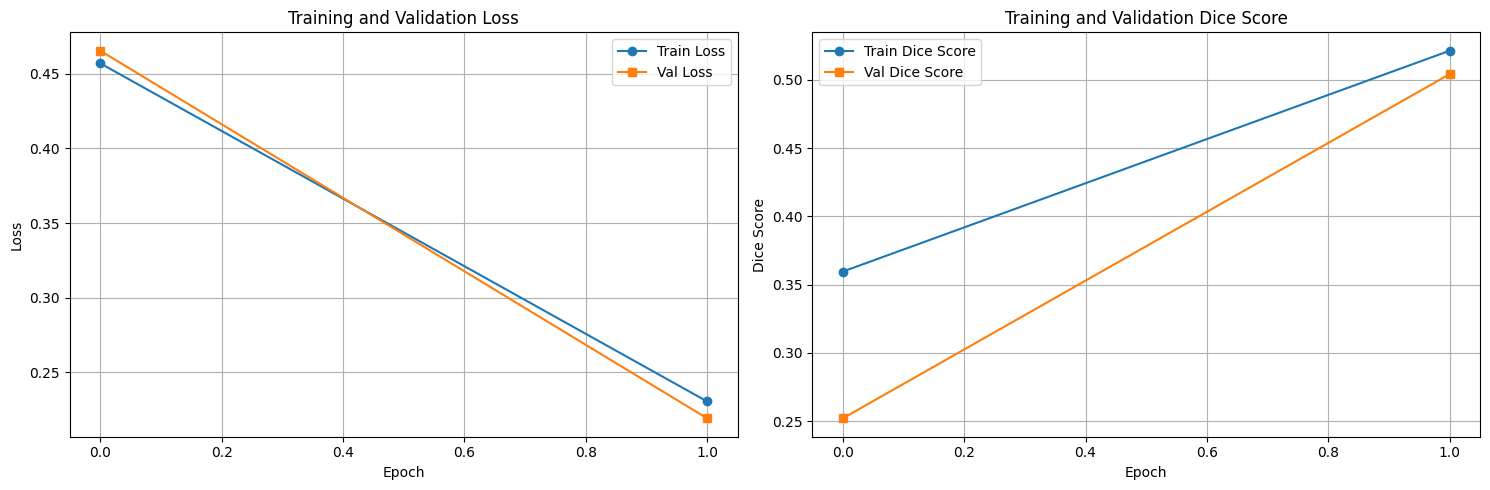

In [24]:
plot_training_history(
    train_losses=history['train_loss'],
    train_metrics=history['train_dice'],
    val_losses=history['val_loss'],
    val_metrics=history['val_dice'],
    metric_name='Dice Score',
    save_path=f'assets/{model_name}/training_history.png'
)

## 9. Visualize Validation Predictions

✓ Saved predictions to assets/best_model_v1.pth/val_predictions.png


✓ Saved predictions to assets/best_model_v1.pth/val_predictions.png


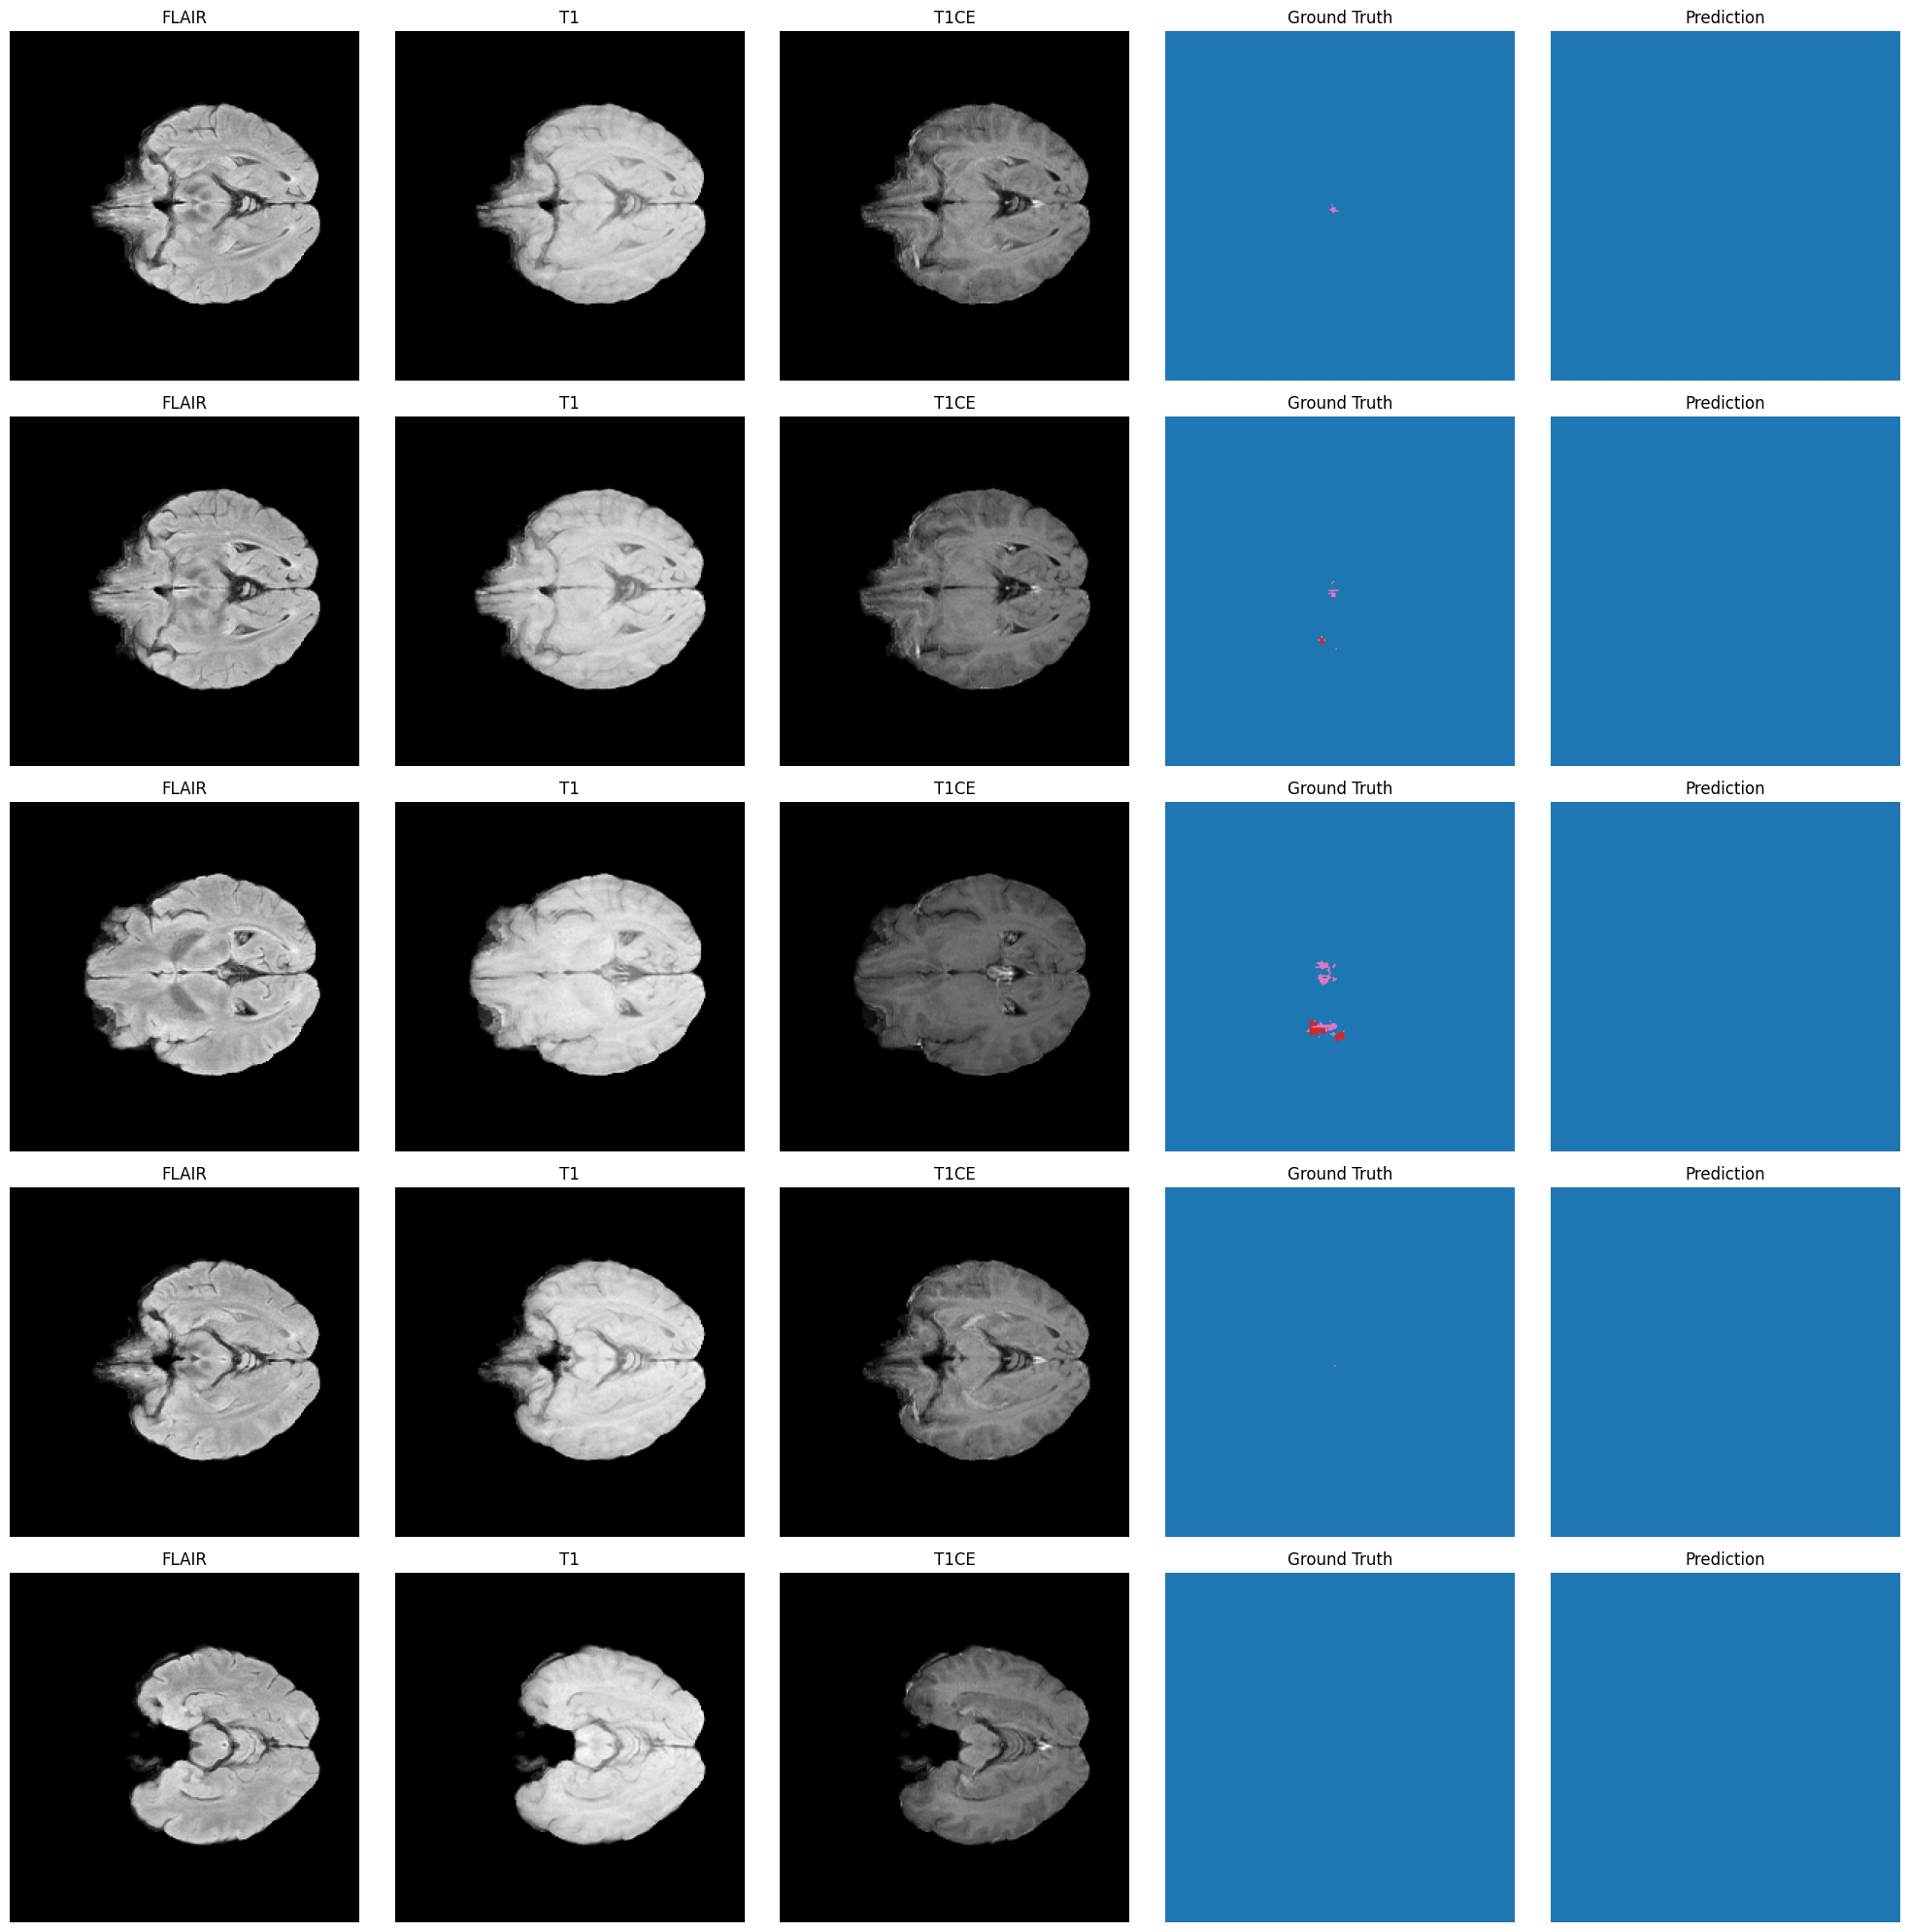

In [31]:
visualize_predictions(
    model=model,
    dataloader=val_loader,
    device=device,
    num_samples=5,
    save_path=f'assets/{model_name}/val_predictions.png'
)

## 10. Evaluate on Test Set

In [26]:
# Load best model checkpoint
checkpoint = load_checkpoint(model, model_save_path, device=device)
epoch = checkpoint.get('epoch', 0)
val_dice = checkpoint.get('val_dice', None)
val_iou = checkpoint.get('val_iou', None)
print(f"Loaded best model from epoch {epoch}")
print(f"Val Dice: {val_dice:.4f}")
print(f"Val IoU: {val_iou:.4f}")

# Import validate function for testing
from utils.training import validate

# Evaluate on test set with both metrics
test_loss, test_metrics = validate(
    model, test_loader, criterion, device, 
    metric_fns={'dice': dice_score, 'iou': iou_score}
)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Dice Score: {test_metrics['dice']:.4f}")
print(f"Test IoU Score: {test_metrics['iou']:.4f}")

Loaded best model from epoch 1
Val Dice: 0.5042
Val IoU: 0.4917


Loaded best model from epoch 1
Val Dice: 0.5042
Val IoU: 0.4917



Test Loss: 0.2202
Test Dice Score: 0.5066
Test IoU Score: 0.4453


In [27]:
# Show all checkpoint contents
print("Checkpoint contents:")
for key, value in checkpoint.items():
    if key not in ['model_state_dict', 'optimizer_state_dict']:
        print(f"  {key}: {value}")

Checkpoint contents:
  epoch: 1
  val_loss: 0.2190505965397908
  val_dice: 0.5042121421474104
  val_iou: 0.4916976327972057


## 11. Visualize Test Predictions

✓ Saved predictions to assets/best_model_v1.pth/test_predictions.png


✓ Saved predictions to assets/best_model_v1.pth/test_predictions.png


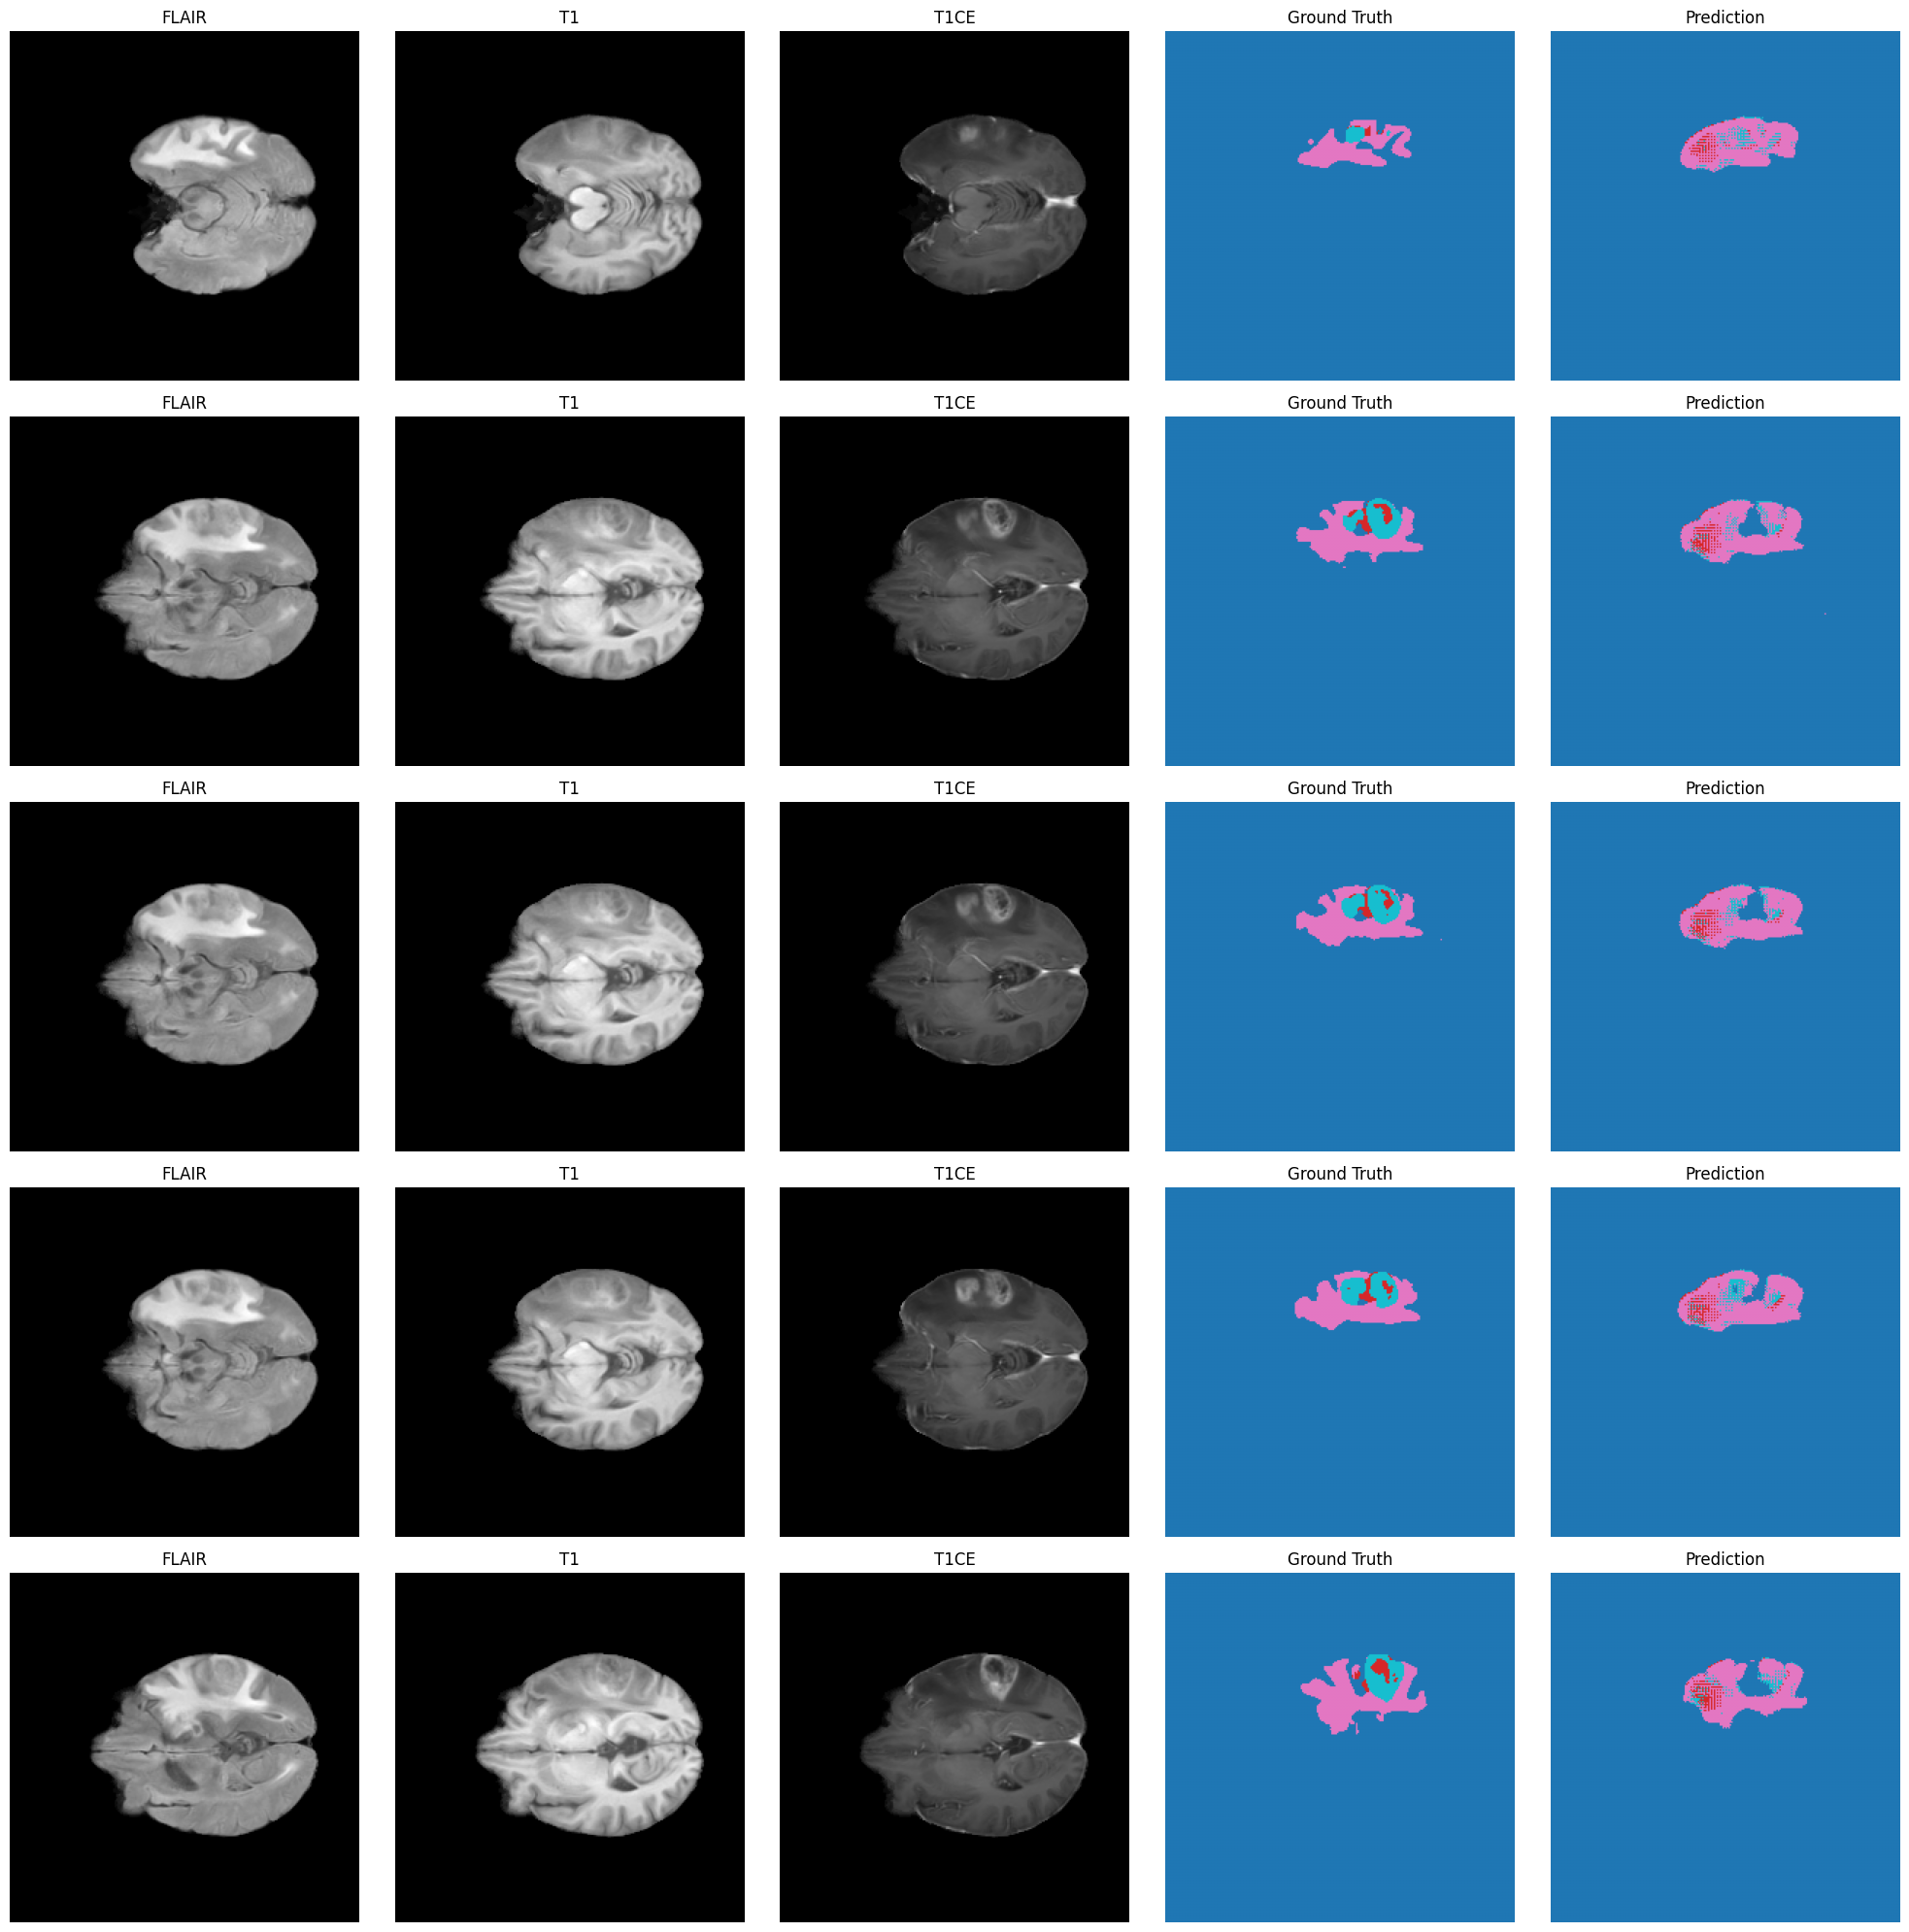

In [28]:
visualize_predictions(
    model=model,
    dataloader=test_loader,
    device=device,
    num_samples=5,
    save_path=f'assets/{model_name}/test_predictions.png'
)

## 12. Overlay-Visualisierung

✓ Saved overlay visualization to assets/best_model_v1.pth/overlay_sample_5.png


✓ Saved overlay visualization to assets/best_model_v1.pth/overlay_sample_5.png


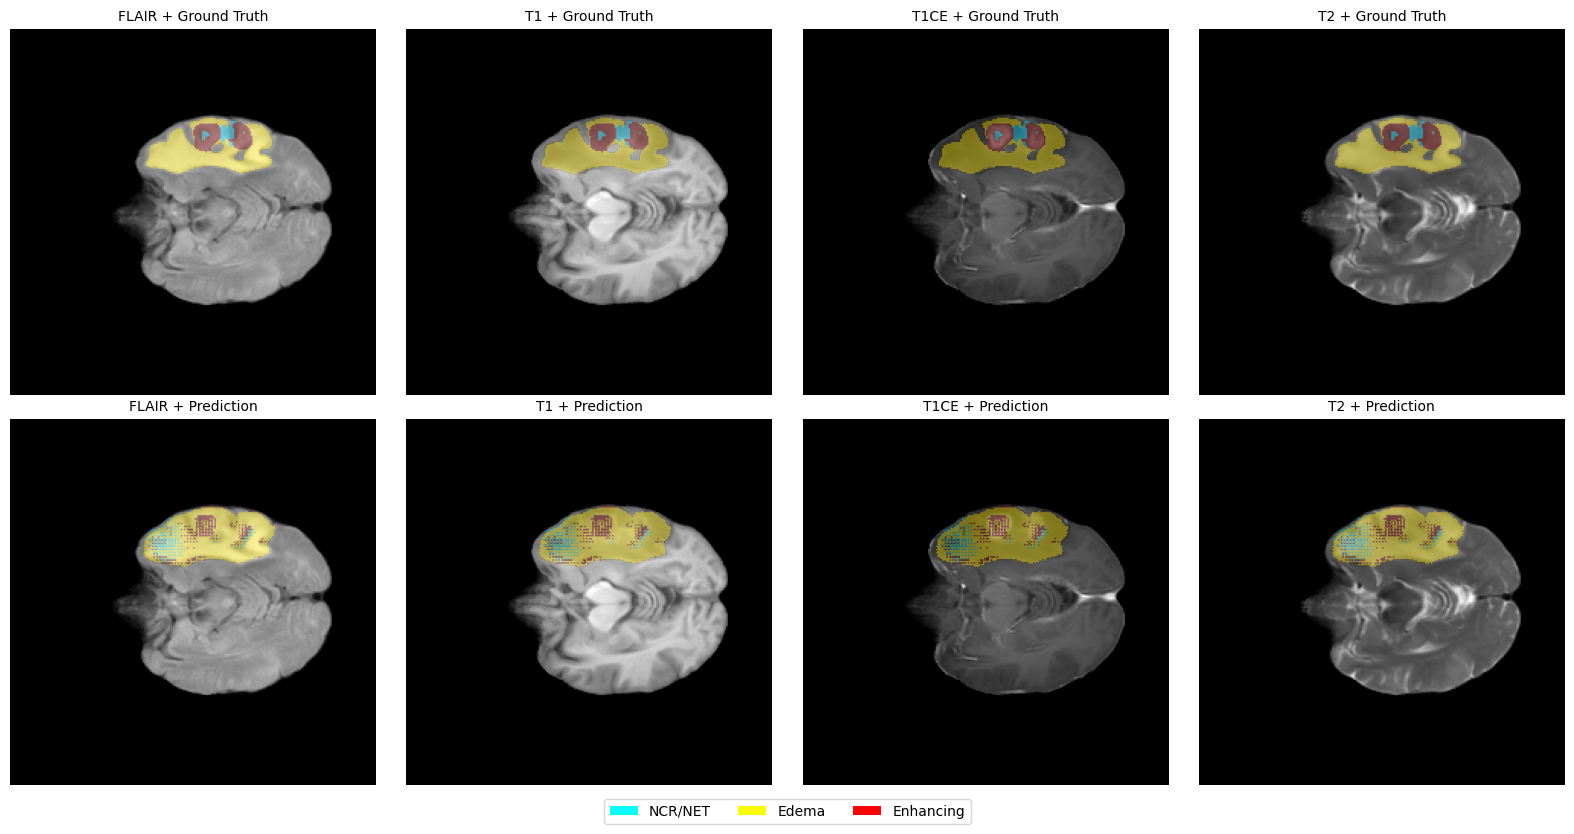

In [29]:
# Hole ein Sample aus dem Test-Set
model.eval()

# Wähle einen interessanten Slice aus dem Test-Datensatz
sample_idx = 5  # Du kannst den Index ändern um verschiedene Samples zu sehen

with torch.no_grad():
    # Hole Daten
    image, mask = test_dataset[sample_idx]
    image_batch = image.unsqueeze(0).to(device)
    
    # Generiere Vorhersage
    output = model(image_batch)
    prediction = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    
    # Konvertiere zu numpy
    image_np = image.cpu().numpy()
    mask_np = mask.cpu().numpy()
    
    # Visualisiere mit Overlay
    visualize_sample_with_overlay(
        image=image_np,
        mask=mask_np,
        prediction=prediction,
        alpha=0.4,  # Transparenz: 0.0 = voll transparent, 1.0 = voll opak
        save_path=f'assets/{model_name}/overlay_sample_{sample_idx}.png'
    )

## 13. Detailed Training History

✓ Saved detailed training history to assets/best_model_v1.pth/detailed_training_history.png


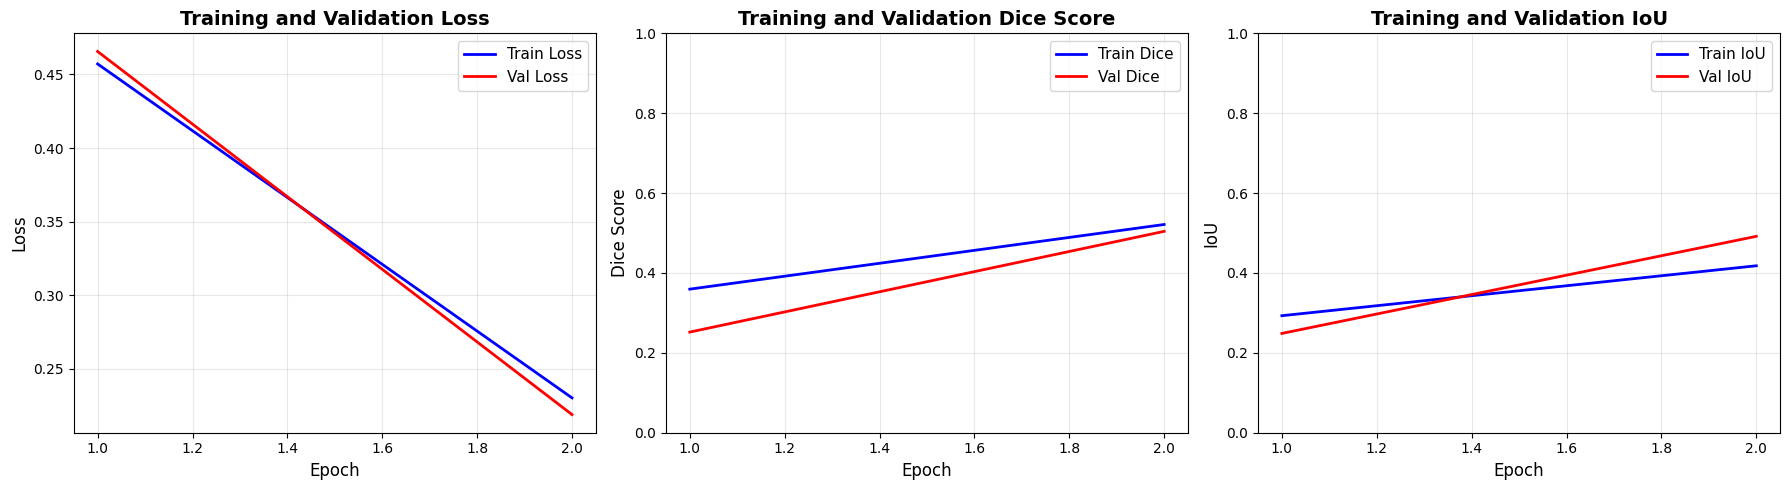

In [30]:
detailed_history = {
    'train_loss': history['train_loss'],
    'val_loss': history['val_loss'],
    'train_dice': history['train_dice'],
    'val_dice': history['val_dice'],
    'train_iou': history['train_iou'],
    'val_iou': history['val_iou'],
}

plot_detailed_training_history(
    history=detailed_history,
    save_path=f'assets/{model_name}/detailed_training_history.png'
)